In [20]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use w1a dataset from LibSVM datasets https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

The original optimization problem for the Support Vector Machine (SVM) is given by
\begin{equation}\label{eq:primal}
  \min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i A_i^\top w) + \frac\lambda2 \|w\|^2
\end{equation}
where $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ is the hinge loss function.
Here for any $i$, $1\le i\le n$, the vector $A_i\in R^d$ is the $i$-th data example, and $y_i\in\{\pm1\}$ is the corresponding label.
  
The dual optimization problem for the SVM is given by 
\begin{equation}\label{eq:dual}
 \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2\lambda} \alpha^\top Y A A^\top Y\alpha
 \text{    such that    $0\le \alpha_i \le 1  \ \forall i$}
\end{equation}
where $Y := \mathop{diag}(y)$, and $A\in R^{n \times d}$ again collects all $n$ data examples as its columns. 

Note that $w$ can be derived from $\alpha$ as
\begin{equation}
    w(\alpha) = \frac{1}{\lambda} A^\top Y \alpha.
\end{equation}

In [21]:
DATA_TRAIN_PATH = 'data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


## Prepare cost and prediction functions

In [22]:
def hinge_loss(y, A, w):
    return np.maximum(1 - y * (A @ w), 0)

In [23]:
def calculate_primal_objective(y, A, w, lambda_):
    """compute the full cost (the primal objective), that is loss plus regularizer.
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    v = hinge_loss(y, A, w)
    return np.sum(v) + lambda_ / 2 * np.sum(w ** 2)

In [24]:
def accuracy(y1, y2):
    return np.mean(y1 == y2)

def prediction(A, w):
    return (A @ w > 0) * 2 - 1

def calculate_accuracy(y, A, w):
    """compute the training accuracy on the training set (can be called for test set as well).
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    predicted_y = prediction(A, w)
    return accuracy(predicted_y, y)

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the i-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [25]:
def project_to_box(tensor):
    return min(max(tensor, 0.0), 1.0)

def calculate_coordinate_update(y, A, lambda_, alpha, w, i):
    """compute a coordinate update (closed form) for coordinate i.
    A: the dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_examples)
    i: the coordinate to be updated
    """        
    # calculate the update of coordinate at index=i.
    a_i, y_i = A[i], y[i]
    old_alpha_i = np.copy(alpha[i])
    
    alpha[i] = project_to_box(old_alpha_i + lambda_ * (1 - y_i * a_i.T @ w) / (a_i.T @ a_i))

    # compute the corresponding update on the primal vector w
    w += (1.0 / lambda_) * (alpha[i] - old_alpha_i) * y_i * a_i
    return w, alpha

In [26]:
def calculate_dual_objective(y, A, w, alpha, lambda_):
    """calculate the objective for the dual problem."""
    return np.sum(alpha)  - lambda_ / 2.0 * np.sum(w ** 2) # w = 1/lambda * A * Y * alpha

In [27]:
def coordinate_descent_for_svm_demo(y, A, trace=False):
    max_iter = 1000000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, A, lambda_, alpha, w, i)
            
        if it % 100000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w)))
    return history

history_cd = coordinate_descent_for_svm_demo(y, A, trace=True)

iteration=0, primal:2391.76500, dual:0.00029, gap:2391.76471


/Users/vogels/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


iteration=100000, primal:271.95666, dual:215.75991, gap:56.19674
iteration=200000, primal:255.47340, dual:222.20794, gap:33.26546
iteration=300000, primal:244.02172, dual:223.67698, gap:20.34474
iteration=400000, primal:239.94807, dual:224.68339, gap:15.26469
iteration=500000, primal:241.85878, dual:225.46912, gap:16.38967
iteration=600000, primal:236.25462, dual:225.96134, gap:10.29328
iteration=700000, primal:234.87232, dual:226.30076, gap:8.57156
iteration=800000, primal:234.70834, dual:226.64232, gap:8.06602
iteration=900000, primal:236.63991, dual:226.93420, gap:9.70571
training accuracy = 0.9951554299555915


# Stochastic gradient descent for SVM

Let's now compare it with SGD on original problem for the SVM

In [28]:
def compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points):
    z = A_batch.dot(w_t) * b_batch
    if z >= 1:
        gradient = lambda_ * w_t
    else:
        gradient = lambda_ * w_t - num_data_points * b_batch * A_batch
    return gradient.reshape(-1)

In [29]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 1000000
    lambda_ = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 100000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w_t)))
    return history


Try different stepsized and find the best one

In [30]:
history_sgd_3 = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=1, trace=True)
history_sgd_4 = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=1, trace=True)
history_sgd_5 = stochastic_gradient_descent_svm_demo(A, y, 1e-5, batch_size=1, trace=True)
history_sgd_6 = stochastic_gradient_descent_svm_demo(A, y, 1e-6, batch_size=1, trace=True)

iteration=0, primal:1017.82120
iteration=100000, primal:347.64340
iteration=200000, primal:369.61653
iteration=300000, primal:330.41647
iteration=400000, primal:366.93519
iteration=500000, primal:327.66575
iteration=600000, primal:347.59749
iteration=700000, primal:347.45056
iteration=800000, primal:359.90214
iteration=900000, primal:366.18849
training accuracy = 0.9878885748889786
iteration=0, primal:2268.18982
iteration=100000, primal:247.56029
iteration=200000, primal:244.16952
iteration=300000, primal:240.86767
iteration=400000, primal:240.06265
iteration=500000, primal:240.48958
iteration=600000, primal:238.71676
iteration=700000, primal:240.27797
iteration=800000, primal:238.81672
iteration=900000, primal:237.70166
training accuracy = 0.9943480016148567
iteration=0, primal:2449.65393
iteration=100000, primal:275.05793
iteration=200000, primal:261.04260
iteration=300000, primal:253.80867
iteration=400000, primal:248.94663
iteration=500000, primal:246.92847
iteration=600000, primal

Lets plot

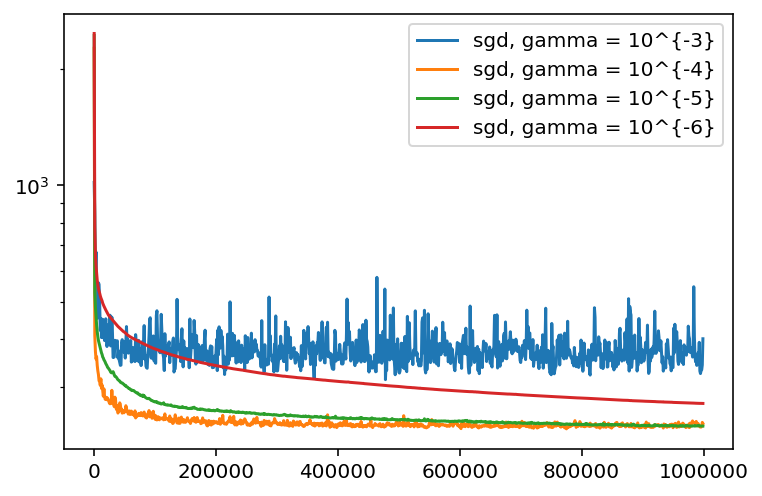

In [31]:
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="sgd, gamma = 10^{-3}")
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="sgd, gamma = 10^{-4}")
plt.semilogy(history_sgd_5["iter"], history_sgd_5["objective_function"], label="sgd, gamma = 10^{-5}")
plt.semilogy(history_sgd_6["iter"], history_sgd_6["objective_function"], label="sgd, gamma = 10^{-6}")
plt.legend()

We see that the best stepsize is $10^{-4}$.

## Compare SGD with Coordinate Descent

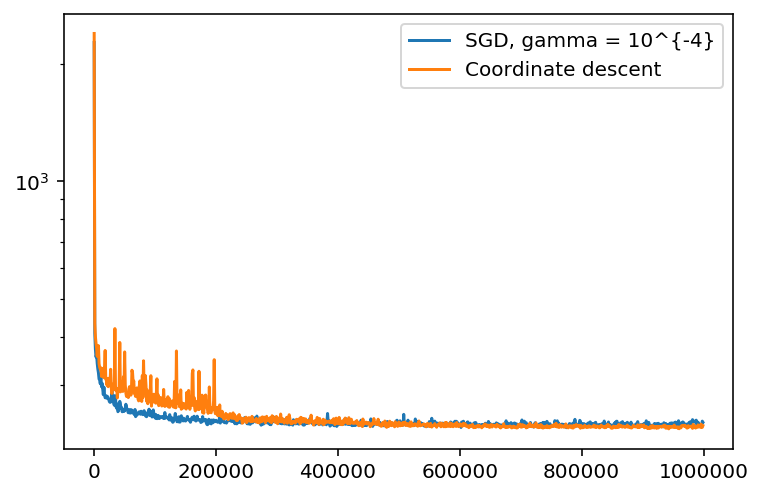

In [32]:
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, gamma = 10^{-4}")
plt.semilogy(history_cd["iter"], history_cd["objective_function"], label="Coordinate descent")
plt.legend()

Time-wise, SGD and coordinate descent have the same per iteration time complexities. On the graph above SGD with the best stepsize converges with approximately the same speed than coordinate descent iteration-wise, while coordinate descent doesn't require any parameter tuning! 